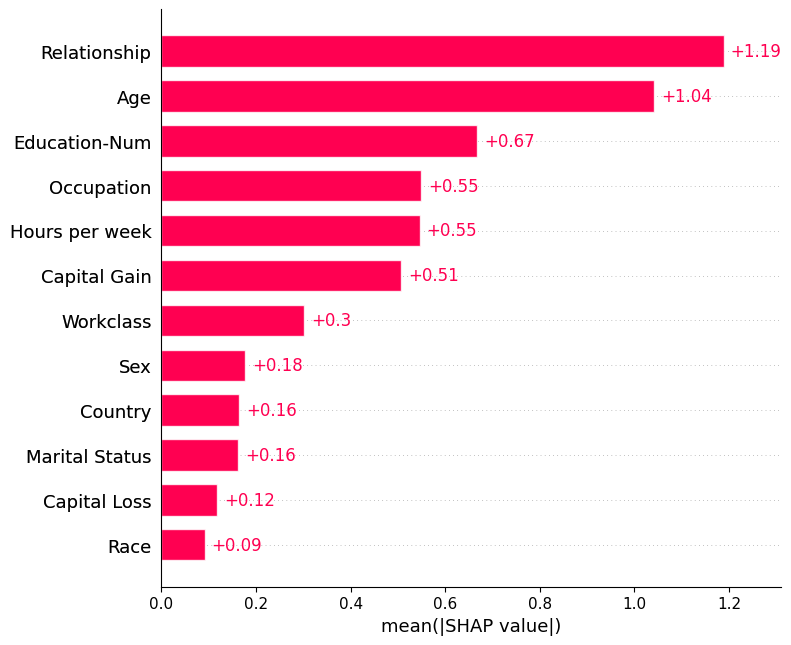

74

In [1]:
import shap
import xgboost
# train XGBoost model
X, y = shap.datasets.adult(n_points=2000)
model = xgboost.XGBClassifier().fit(X, y)


# compute SHAP values
explainer = shap.Explainer(model, X)
shap_values = explainer(X)
shap.plots.bar(shap_values,max_display=12)

y_binary = [1 if income == True else 0 for income in y]
predict = model.predict(X)
Wrong_pred = []
for i in range(len(predict)):
    if predict[i] != y_binary[i]:
        Wrong_pred.append(i)
len(Wrong_pred)

Initial prediction: 1, Initial probability: 0.6770620346069336
Counterfactual prediction: 0, Counterfactual probability: 0.053557388484478
The prediction is successfully flipped.


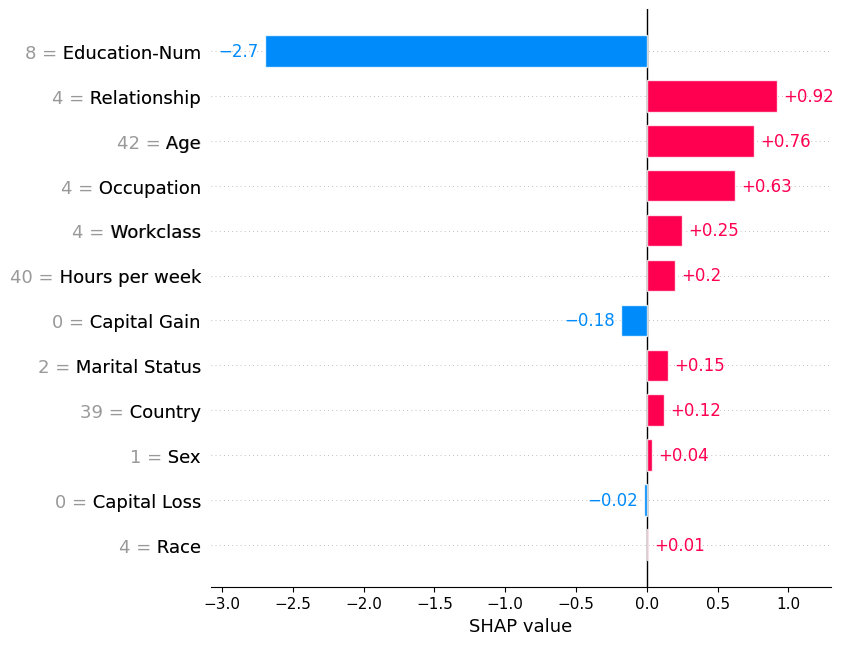

In [2]:
import xgboost
import shap
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Load the dataset
X, y = shap.datasets.adult(n_points=2000)
model = xgboost.XGBClassifier().fit(X, y)

# Convert y to binary high-income and low-income
y_binary = np.array([1 if income == True else 0 for income in y])

# Compute SHAP values
explainer = shap.Explainer(model, X)
shap_values = explainer(X)
current_instance = X.iloc[100]  # Example: first instance
current_shap_values = shap_values[100]

# Predict the initial outcome
initial_prediction = model.predict(current_instance.values.reshape(1, -1))[0]
initial_probability = model.predict_proba(current_instance.values.reshape(1, -1))[0, 1]
print(f"Initial prediction: {initial_prediction}, Initial probability: {initial_probability}")


# Define the objective function for optimization
def objective_function(x):
    # Create a DataFrame with the current instance modified by x
    new_instance = pd.DataFrame([current_instance.values], columns=X.columns)
    new_instance.iloc[0] = x
    
    # Predict the probability of the positive class (high income)
    pred = model.predict_proba(new_instance)[0, 1]
    
    # We want to flip the outcome, so we minimize the distance to the decision boundary (0.5)
    return abs(pred - 0.5)

# Constraints to keep the modified instance similar to the original instance
constraints = [{'type': 'eq', 'fun': lambda x: np.linalg.norm(x - current_instance.values) - 0.1}]

# Bounds for each feature to ensure they stay within valid ranges
bounds = [(X[col].min(), X[col].max()) for col in X.columns]

# Optimize to find the counterfactual instance
result = minimize(objective_function, current_instance.values, bounds=bounds, constraints=constraints, method='SLSQP')

# The counterfactual instance

counterfactual_instance = [[42.,  4., 8.,  2.,  4.,  4.,  4.,  1.,  0.,  0., 40., 39.],
                           [42.,  4., 9.,  2.,  4.,  4.,  4.,  1.,  0.,  0., 40., 39.],
                           [42.,  4., 10.,  2.,  4.,  4.,  4.,  1.,  0.,  0., 40., 39.],
                           [42.,  4., 11.,  2.,  4.,  4.,  4.,  1.,  0.,  0., 40., 39.]
                           ]

counterfactual_instance_df = pd.DataFrame(counterfactual_instance, columns=X.columns)

# Predict the outcome for the counterfactual instance
counterfactual_prediction = model.predict(counterfactual_instance_df)[0]
counterfactual_probability = model.predict_proba(counterfactual_instance_df)[0, 1]
print(f"Counterfactual prediction: {counterfactual_prediction}, Counterfactual probability: {counterfactual_probability}")

# Ensure the prediction is flipped
if counterfactual_prediction != initial_prediction:
    print("The prediction is successfully flipped.")
else:
    print("The prediction is not flipped. Adjust constraints or bounds and try again.")

# Compute SHAP values for the counterfactual instance
counterfactual_shap_values = explainer(counterfactual_instance_df)
shap.plots.bar(counterfactual_shap_values[0],max_display=12)


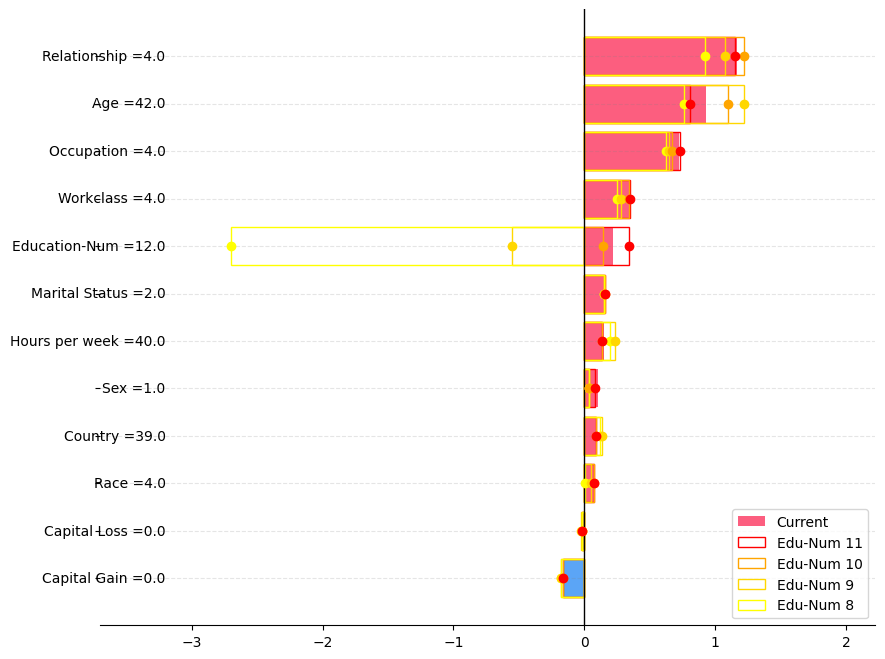

In [11]:
import matplotlib.pyplot as plt
import shap
import pandas as pd
import numpy as np

# Assuming current_shap_values and counterfactual_shap_values are already defined
# And X is the dataset used for feature columns

# Create DataFrame for the current and counterfactual SHAP values
shap_df = pd.DataFrame({
    'feature': X.columns,
    'current_value': current_shap_values.values,
    'counterfactual_value_0': counterfactual_shap_values.values[0],
    'counterfactual_value_1': counterfactual_shap_values.values[1] if len(counterfactual_shap_values.values) > 1 else np.nan,
    'counterfactual_value_2': counterfactual_shap_values.values[2] if len(counterfactual_shap_values.values) > 2 else np.nan,
    'counterfactual_value_3': counterfactual_shap_values.values[3] if len(counterfactual_shap_values.values) > 3 else np.nan,
    'current_feature_value': current_shap_values.data,
    'counterfactual_feature_value': counterfactual_shap_values.data[0],
})

# Sort by current SHAP values
shap_df = shap_df.sort_values(by='current_value', ascending=False).reset_index(drop=True)

# Define colors for positive and negative SHAP values
colors = ['#FB1A49' if val >= 0 else '#157FF3' for val in shap_df['current_value']]
# Plot SHAP values for the current instance
plt.figure(figsize=(10, 8))

# Plot current SHAP values
plt.barh(shap_df['feature'], shap_df['current_value'], color=colors, label='Current',alpha=0.7)

# Plot counterfactual SHAP values as a background bar with lower opacity
plt.barh(shap_df['feature'], shap_df['counterfactual_value_3'], color='red', edgecolor=['red'],fill=False, label='Edu-Num 11')
plt.barh(shap_df['feature'], shap_df['counterfactual_value_2'], color='orange', edgecolor=['orange'],fill=False, label='Edu-Num 10')
plt.barh(shap_df['feature'], shap_df['counterfactual_value_1'], color='#FFD700', edgecolor=['#FFD700'],fill=False, label='Edu-Num 9')
plt.barh(shap_df['feature'], shap_df['counterfactual_value_0'], color='#FFFF00', edgecolor=['#FFFF00'], fill=False, label='Edu-Num 8')




# plt.barh(shap_df['feature'], shap_df['current_value'], color=colors, label='Current')
# Plot current SHAP values with borders only
# plt.barh(shap_df['feature'], shap_df['current_value'], edgecolor=colors, alpha=1.0, label='Current')

# Add a black vertical line at x=0
plt.axvline(x=0, color='black', linewidth=1)

# Add feature values next to the y-axis and on the bars
# for idx, row in shap_df.iterrows():
#     if row['current_value'] >= 0:
#         plt.text(row['current_value'] + 0.05, idx - 0.3, f"{row['current_value']:.2f}", va='center', color='#FB1A49')
#     else:
#         plt.text(row['current_value'] - 0.05, idx - 0.2, f"{row['current_value']:.2f}", va='center', ha='right', color='#157FF3')

# Create y-axis labels with feature names and corresponding feature values
ax = plt.gca()

# Set y-tick labels with custom formatting
min_value = min(shap_df['current_value'].min(), shap_df['counterfactual_value_0'].min(), shap_df['counterfactual_value_1'].min(), shap_df['counterfactual_value_2'].min())
max_value = max(shap_df['current_value'].max(), shap_df['counterfactual_value_0'].max(), shap_df['counterfactual_value_1'].max(), shap_df['counterfactual_value_2'].max())

for idx, row in shap_df.iterrows():
    plt.scatter([row['counterfactual_value_0']], [idx], color='#FFFF00',zorder=5)
    plt.scatter([row['counterfactual_value_1']], [idx], color='#FFD700', zorder=5)
    plt.scatter([row['counterfactual_value_2']], [idx], color='orange', zorder=5)
    plt.scatter([row['counterfactual_value_3']], [idx], color='red', zorder=5)
    
for i, row in shap_df.iterrows():
    ax.text(min_value - 0.5, i, f"{row['feature']} ={row['current_feature_value']:.1f}", va='center', ha='right', color='black', fontsize=10)
    # if row['counterfactual_feature_value'] != row['current_feature_value']:
    #     ax.text(min_value - 0.5, i + 0.3, f"({row['counterfactual_feature_value']:.1f})", va='center', ha='right', color='orange', fontsize=10)

# Remove the top, right, and left borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# Invert y-axis to have the highest value on top
plt.gca().invert_yaxis()

# Add horizontal grid lines with dashed style
plt.gca().yaxis.grid(True, linestyle='--', which='both', color='gray', alpha=0.2)

# Hide the default y-tick labels
ax.set_yticklabels([])

# Adjust x-axis limits
plt.gca().set_xlim(left=min_value - 1, right=max_value + 1)

# Show the legend
plt.legend()

plt.show()
